# 灰度变换和空间滤波

以下讨论均属于空间域。

## 灰度变换函数

在之前的基础知识中，我们知道对图像的空间操作可以使用一个作用于一小块邻域的算子。这个邻域最小可以仅作用于一个点，称为**点处理**。灰度变换函数就是用在点处理的算子。

还是以莱纳图为例，下面展示了几种灰度变换函数：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

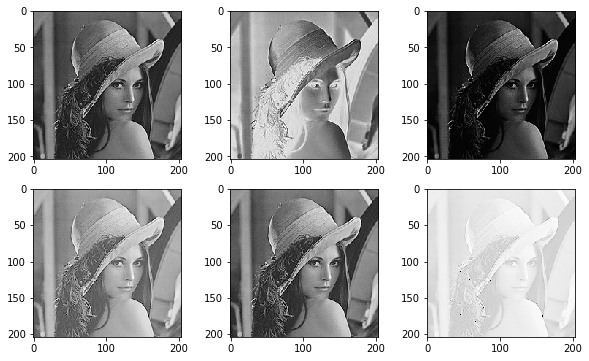

In [2]:
img = cv.imread('lena.jpg', 0)
img = img / 255 # 重整为[0, 1]的浮点数
plt.figure(figsize = (10, 6))
plt.subplot(231)
plt.imshow(img, cmap = 'gray')
plt.subplot(232)
plt.imshow(1 - img, cmap = 'gray') # 负片
plt.subplot(233)
plt.imshow(img ** 2, cmap = 'gray')
plt.subplot(234)
plt.imshow(np.sqrt(img), cmap = 'gray')
plt.subplot(235)
plt.imshow(np.log(1 + img), cmap = 'gray') # 对数变换
plt.subplot(236)
plt.imshow(img ** 0.10, cmap = 'gray') # 幂律（伽马）变换
plt.show()

使用灰度变换函数，可以对图像的对比度进行调整。

## 分段线性变换函数

上面介绍的灰度变换函数都是对整个灰度范围进行改变，但对于某些图片来说，可能仅仅在某些亮度区域的对比度不尽如人意。这时候就可以使用分段函数对某一段灰度区做更改。

## 比特平面分层

在灰度图像中，每一个像素点都是以同样位数的二进制数存储的。比特分层的想法是，把像素点的各位提取出来组成图像（比如一张八位的图像就可以组成八张分层图像）。这里很有利的是，提取出来的每一张图像都是一张二值图像。

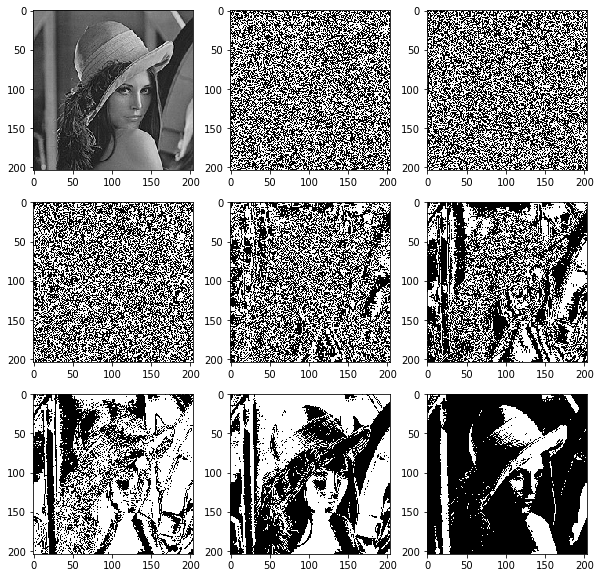

In [3]:
img = cv.imread('lena.jpg', 0)
plt.figure(figsize = (10, 10))
plt.subplot(3, 3, 1)
plt.imshow(img, cmap = 'gray')
for i in range(2, 10):
    plt.subplot(3, 3, i)
    plt.imshow(img & (1 << (i - 2)), cmap = 'gray')
plt.show()

这样的技术在图像压缩领域有着很好的效果：可以看到，越低位数的二值图像越接近随机，它们对原图像的贡献是微乎其微的。当需要压缩一张图像的时候，可以使用位数较高的分层组合起来代替原始图像。

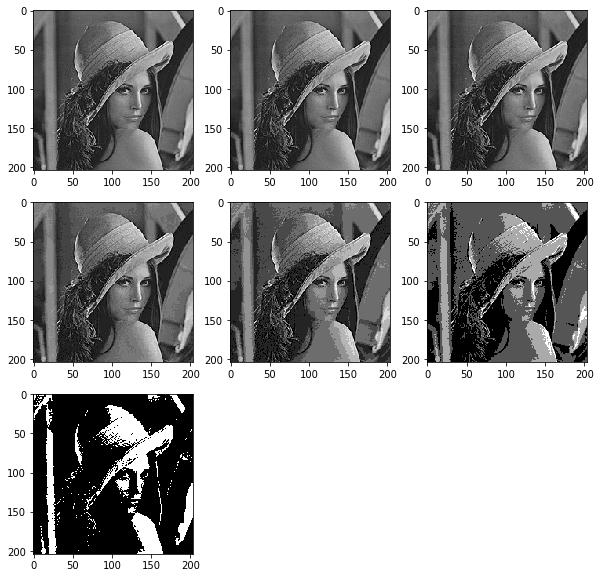

In [12]:
plt.figure(figsize = (10, 10))
for i in range(1, 8):
    plt.subplot(3, 3, i)
    plt.imshow((img >> i) / (256 >> i), cmap = 'gray')
plt.show()

随着合并层数的减少，图像的细节越来越弱，但仍然可以看到图像的大体状态。

## 直方图均衡

在上一章中讨论了图像的直方图所代表的意义。对于一张图像，如果它的像素倾向于占据整个可能的灰度级并且分布均匀，那么该图像会有高对比度的外观并展示灰色调的较大变化。最终的效果就是，该图像将是一幅灰度细节丰富且动态范围较大的图像。

下面是莱纳图原图和加噪之后的莱纳图的直方图比较

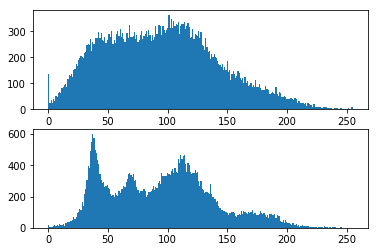

In [5]:
img = cv.imread('.//noise//1.jpg', 0)
img2 = cv.imread('lena.jpg', 0)
plt.subplot(211)
plt.hist(img.ravel(), bins = 256)
plt.subplot(212)
plt.hist(img2.ravel(), bins = 256)
plt.show()

### 数学模型

要说明直方图均衡的概念，我们需要建立一个数学模型：

假如有连续随机变量$X$和$Y$，它们之间通过一个函数$T$连接，这里知道，$T$是单的、满的、增的：
$$
    Y = T(X)
$$
其中，$X$是一个在定义域内概率不等的随机变量，而$Y$是一个均匀分布的随机变量，要求这个$T$。

这里还已知$X$的分布函数为$F_X(x)$，$Y$的分布函数（CDF）为$F_Y(y)$，概率密度函数（PDF）分别为$f_X(x)$和$f_Y(y)$。

由以上条件可以推出：

$$
    F_Y(y) = P\{Y\leq y\}\\
    =P\{T(X)\leq y\}\\
    =P\{X\leq T^{-1}(y)\}\\
    =F_X(T^{-1}(y))
$$

由随机变量函数的分布的相关性质可以知道
$$
    f_Y(y) = f_X(x)\left| \frac{dx}{dT(x)}\right|
$$

推导到这里，我们把图像套进这个数学模型里面去：

在上一章中的直方图部分我们知道一张图像可以对应一个频率直方图，当把频率视为概率的时候，一张图像可以看作在全灰度值上的随机变量。如果能够找到一个灰度变换函数$T$，使得**服从任意概率分布的图像**都可以产生一个服从均匀分布的图像。

### 直方图均衡的数学依据

设输入图像为$X$，输出图像为$Y$，将其视作两个随机变量，其定义域在$[0, L - 1]$，有一个定义域和值域均在$[0, L - 1]$的一个函数$T$，有

$$
    Y = T(X)
$$

由上节的结论，有

$$
    f_Y(y) = f_X(x)\left| \frac{dx}{dy}\right|
$$

我们想要让$Y$的分布为均匀分布，这就是说，$Y$的PDF为：

$$
    f_Y(y) = \frac{1}{L - 1},\quad 0 < y \leq L - 1
$$

将上面两式合并，就是

$$
    \frac{1}{L - 1} = f_X(x)\left|\frac{dx}{dy}\right|\\
    dy = (L - 1)f_X(x)dx\\
    \int_0^x dy = (L - 1)\int_0^x f_X(t)dt\\
    T(x) = (L - 1)\int_0^x f_X(t)dt
$$

这样，我们就求出了$T$的形式。

### 实验

为了证明这个函数的可行性，下面来做一个简单的实验。首先需要一张灰度直方图较为集中的图像：

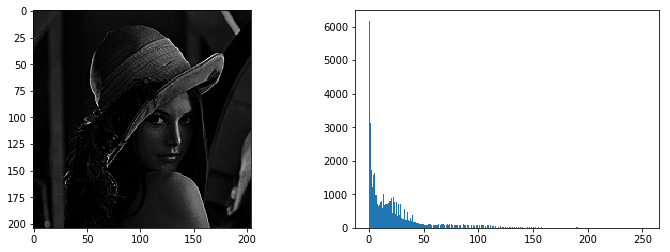

In [18]:
img = cv.imread('lena.jpg', 0)
img = np.floor((img / 256) ** 3 * 256)
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.imshow(img, cmap = 'gray')
plt.subplot(122)
plt.hist(img.ravel(), bins = 256)
plt.show()

In [39]:
def histeq(f, nlev):
    # f: input image, nlev: depth of image
    res = f.copy()
    M, N = f.shape
    value = [f[f <= i].size for i in range(nlev)] # 先存储转换函数值，提高计算速度
    T = np.frompyfunc(lambda p: value[int(p)], 1, 1) # 编写自定义ufunc
    res = T(res) * (nlev - 1) / f.size
    return res.astype(np.float) # 自定义函数的返回值类型为object，需要进行转换

上面实现了一个**离散形式**的直方图均衡函数，下面来测试一下（上面的函数经过了几次修改，能达到不错的运算速度）：

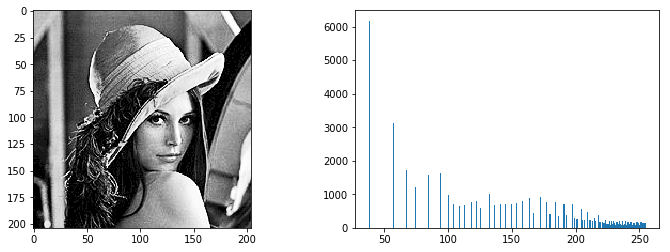

In [43]:
test = histeq(img, 256)
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.imshow(test, cmap = 'gray')
plt.subplot(122)
plt.hist(test.ravel(), bins = 256)
plt.show()

可以看到，上面的函数使得图像的直方图延展开，图像的视觉效果变得更加清晰而且对比度强烈。

下面的图像展示了使用`MATLAB`做出的同样效果（`histeq_test.m`），说明我们这个函数能够达到预期的效果。

![](直方图均衡（MATLAB）.png)

### 直方图匹配

由于图像的灰度值都是离散化的，所以直方图的均衡函数$T(x)$就是一个阶梯函数。从上一节实现的函数中把均衡函数拿出来，可以得到图像：

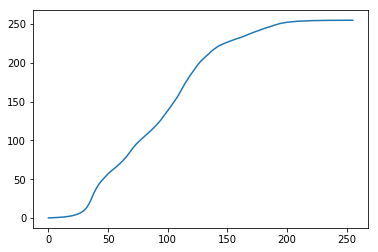

In [61]:
img = cv.imread('lena.jpg', 0)
def T(x):
    # pic: the Image, x: the degree of gray
    return 255 / img.size * img[img <= x].size
func = np.frompyfunc(T, 1, 1)
x = np.arange(256)
y = func(x).astype(np.float)
plt.plot(x, y)
plt.show()

可以看到，该均衡函数并不平整。在某些应用中，可能需要定制均衡函数。

另外，上面接触到的直方图均衡都是针对全局的，而如果把均衡的范围缩小在一个邻域内，就可以得到局部增强的过程：就像上一章实现的图像模糊一样，每次对一块区域进行均衡。

### 图像中的统计量

如上一章所说，图像可以用统计量来描述。

In [72]:
img = cv.imread('lena.jpg', 0)
print(np.mean(img)) # 均值
print(np.var(img)) # 方差
print(np.std(img)) # 标准差
print(np.mean(img ** 3)) # 3阶原点矩
print(np.mean((img - np.mean(img)) ** 3)) # 3阶中心矩

94.01780565167243
2012.8308776915635
44.86458377931933
109.39117166474433
33264.14094876884


在大多数情况下，图像内像素数量庞大，完整计算统计量是不必要的，这个时候可以用采样的方法来估计统计量的值。

In [87]:
test = img[::5, ::5] # begin:end:step，和MATLAB不一样！
print(np.mean(test)) # 均值
print(np.var(test)) # 方差
print(np.std(test)) # 标准差
print(np.mean(test ** 3)) # 3阶原点矩
print(np.mean((test - np.mean(test)) ** 3)) # 3阶中心矩

93.69482450922071
2027.4577305016242
45.02729983578433
110.85246876859013
31793.705070790627


可以看到，它们的数值还是比较接近的。